In [23]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
from sklearn.preprocessing import OneHotEncoder
from pyod.models.hbos import HBOS

## 1. Lectura base de datos

In [25]:
data_path = r"D:\DANE - Contrato\2024\Operativo Barrido\Data"
emicron = pd.read_csv(os.path.join(data_path,"emicron_establecimientos.csv"),header = 0)
emicron = emicron[emicron['OLA']==2022].reset_index(drop=True)
emicron.drop('OLA',axis=1,inplace=True)

#### One-hot encoding

In [26]:
emicron_ohe = emicron.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())
#drop_enc_df.drop('COD_DEPTO_5', axis=1, inplace = True) # Utilizar como categoría de referencia 5: Antioquia

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_ubi = OneHotEncoder().fit(emicron_ohe[['UBICA']])
drop_enc = ohe_ubi.transform(emicron_ohe[['UBICA']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_ubi.get_feature_names_out())
drop_enc_df.drop('UBICA_3', axis=1, inplace = True)  # Utilizar como categoría de referencia 3: Vivienda (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())
#drop_enc_df.drop('GRUPOS4_2', axis=1, inplace = True) # Utilizar como categoría de referencia 2: Industria Manufacturera

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_conta = OneHotEncoder().fit(emicron_ohe[['REG_CONT']])
drop_enc = ohe_conta.transform(emicron_ohe[['REG_CONT']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_conta.get_feature_names_out())
#drop_enc_df.drop('REG_CONT_4', axis=1, inplace = True) # Utilizar como categoría de referencia 4: No lleva registros (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [27]:
emicron_ohe.drop(['COD_DEPTO','UBICA','GRUPOS4','REG_CONT'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [28]:
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(emicron_ohe)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [29]:
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  -174.1943442943894


In [30]:
scores = hbos.decision_function(emicron_ohe)
pred = hbos.predict(emicron_ohe)

In [31]:
emicron['Anomaly'] = pred

In [32]:
emicron['Anomaly'].value_counts()

0    21642
1     1140
Name: Anomaly, dtype: int64

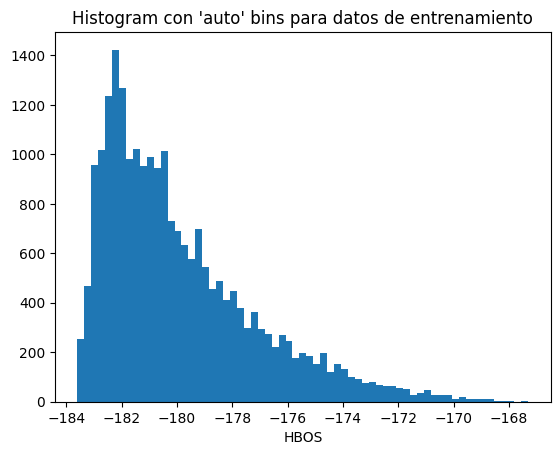

In [33]:
plt.hist(scores, bins = 'auto')
plt.title("Histogram con 'auto' bins para datos de entrenamiento")
plt.xlabel('HBOS')
plt.show()

In [34]:
threshold = hbos.threshold_

In [18]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [35]:
descriptive_stat_threshold(emicron_ohe, scores, threshold)

,Group,Count,Count %,VENTAS_MES_ANTERIOR,POTTOT,REMUNERACION_TOTAL,CYG,CPAM,IDRUT,CAMCOMER,...,COD_DEPTO_88,UBICA_1,GRUPOS4_2,GRUPOS4_3,GRUPOS4_4,REG_CONT_1,REG_CONT_2,REG_CONT_3,REG_CONT_4,Anomaly_Score
0,Normal,21642,94.99605,3382168.12,0.36,200451.71,2264294.60,0.72,0.40,0.27,...,0.01,0.41,0.14,0.49,0.37,0.02,0.10,0.41,0.47,-180.28
1,Outlier,1140,5.00395,18929701.04,3.00,3655481.36,13228565.86,0.70,0.99,0.96,...,0.06,0.88,0.28,0.32,0.39,0.53,0.36,0.10,0.01,-172.44
